# Parameter inference


In this notebook, we introduce PyBEAM's parameter inference tool. If you have not done so already, look at the "Choosing your model" and "Using your model" notebooks since we will be using tools introduced their in here.

Once you have done this, import PyBEAM's pre-coded sub-module.


In [1]:
# import PyBEAM's pre-coded module
import pybeam.precoded as pbp


We first define a model we would like to study. For this example, we use the simpleDDM model with no extensions discussed in "Choosing your model" and "Using your model". We also examine the model parameters function to make sure it has the parameters we desire. For this model, they should be the non-decision time 't_nd', the relative start 'w', the drift rate 'mu', and the decision threhsold locations 'b'.


In [2]:
# call simpleDDM model
model = pbp.simpleDDM()

# outputs which parameters your model uses
model.parameters()


['tnd', 'w', 'mu', 'b']

Next, we simulate a data set using the simulate tool discussed in "Using your notebook". We also plot the data set and its likelihood function using the plot_rt function.


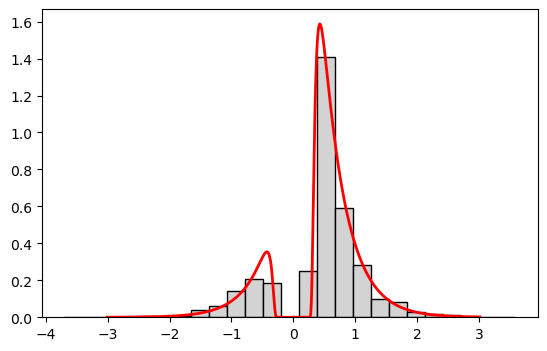

In [3]:
# parameters for synthetic data
phi = {'tnd' : 0.25,  # non-decision time
         'w' : 0.5,   # relative start point
        'mu' : 1.0,   # drift rate
         'b' : 0.75}  # decision threshold location

# generate synthetic data
rt = pbp.simulate(N_sims = 1000,  # number of data points to simulate
                   model = model, # dictionary containing model information
                     phi = phi)   # parameters used to simulate data

# plot data and model likelihood function
fig = pbp.plot_rt(model = model, # dictionary containing model information 
                    phi = phi,   # parameters used for model rt distribution
                 rt_max = 3.0,
                     rt = rt);   # dictionary of simulated rt data


Now that we have defined our model and generated a data set, we can run the MCMC inference program. To do so, we first need to define all priors used by the model. This is done by generating a dicitonary containing the prior information. In this case, we have four parameters and only one data set to fit, so we require four priors. The dictionary keys are arbitrary, while the values are the priors themselves are are written in PyMC syntax (made into strings). In this case, we use PyMC's uniform priors, with the syntax:

    Uniform( "prior name" , lower = (lower bound of prior) , upper = (upper bound of prior) )


In [4]:
# define model priors
p = {'p_tnd' : 'Uniform("t_nd", lower = 0.0, upper = 0.5)', # non-decision time prior
       'p_w' : 'Uniform("w", lower = 0.1, upper = 0.9)',    # relative start point prior
      'p_mu' : 'Uniform("mu", lower = -5.0, upper = 5.0)',  # drift rate prior
       'p_b' : 'Uniform("b", lower = 0.1, upper = 2.0)'}    # decision threshold prior


We next define a dictionary which sets which priors are associated with what parameters and which data set. This dictionary contains the keys output model.parameters(). The values of these keys indicate which priors from the prior dictionary are associated with each parameter. So, for example, parameter 'tnd' has the prior associated with prior key 'p_tnd' (p['p_tnd']).

In addition to the parameters, a key 'rt' is required. This key contains the data you would like to fit. This data set must be in the same form as that output by the simulate model function. It must have two keys, 'rt_upper' and 'rt_lower'. The values for these keys must be 1D lists/numpy arrays containing the reaction time data for the two choices (crossing the upper and lower decision thresholds, respectively).

This dictionary is then loaded into one last dictionary which will be input into the function. This step is added in case you would like additional conditions in your model. For this example, we only have one condition, but the notebook tutorial2 dicusses how to use multiple conditions.


In [5]:
# define model conditions
c0 = {'rt' : rt,      # dictionary containing reaction time data
     'tnd' : 'p_tnd', # prior for non-decision time, references p['p_tnd']
       'w' : 'p_w',   # prior for relative start point, references p['p_w']
      'mu' : 'p_mu',  # prior for the drift rate, references p['p_mu']
       'b' : 'p_b'}   # prior for the threshold, references p['p_b']

# load conditions into dictionary
c = {0 : c0}


We now run PyBEAM's parameter inference program, inference. This takes the input data and priors and outputs posteriors for each parameter. It requires inputs of the model dictionary, the prior dictionary, the conditions dictionary, chains (how many mcmc chains you want), cores (how many cpu cores to run those chains on), and file name (a string containing the file name to save the posteriors to).

This function has a few additional optional inputs that generally are not needed. These include resolution settings and MCMC solvers different than the default. These are disucssed fully in the "precoded_functions" notebook in folder Tutorials on the PyBEAM github.


In [6]:
# run parameter inference
idata = pbp.inference(model = model,       # model dictionary
                     priors = p,           # priors dictionary
                 conditions = c,           # conditions dictionary
                    samples = 25000,       # number of MCMC samples
                     chains = 3,           # number of MCMC chains
                      cores = 3,           # number of CPU cores to run chains on
                  file_name = 'simpleDDM') # file output


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [b, mu, w, t_nd]


Sampling 3 chains for 0 tune and 25_000 draw iterations (0 + 75_000 draws total) took 44 seconds.


PyBEAM contains two more useful functions. The first, plot_idata, plots the posteriors output by the program. The second, summary, provides posterior summary statistics. They both accept input of the file name, in addition to a 'burnin' which sets how many of the samples need to be thrown out from the beginning.

Both functions are from the arviz library, so see the arviz/pymc documentation for more information about them.


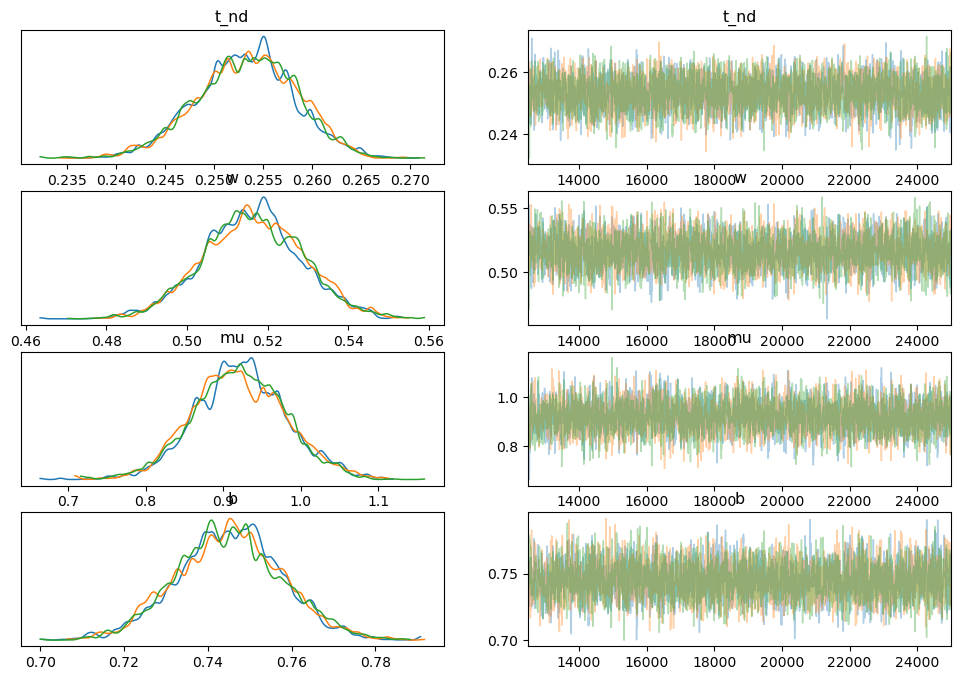

In [7]:
# plot posteriors
pbp.plot_idata(file_name = 'simpleDDM', burnin = 12500);


In [9]:
# summary of posteriors
pbp.summary(file_name = 'simpleDDM', burnin = 12500)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t_nd,0.253,0.005,0.244,0.263,0.000,0.000,2782.0,3838.0,1.0
w,0.516,0.012,0.494,0.540,0.000,0.000,2537.0,3635.0,1.0
mu,0.921,0.060,0.813,1.038,0.001,0.001,2431.0,3175.0,1.0
b,0.745,0.013,0.721,0.769,0.000,0.000,2583.0,3691.0,1.0
